# Import modules. Run once

In [2]:
%matplotlib

# import system modules
import sys
import os.path
import matplotlib.pyplot as plt   
from IPython.display import clear_output
import numpy as np
import json
import visa
import time
from scipy import optimize
from math import pi

# Add path
#sys.path.remove(r'\\shared.ad.syr.edu\AS-Filer\PHY-PRL-labshare\Programs\python\Drivers')
#sys.path.append(r'Z:\User\Jaseung\programs\pythonCode\Instrument Driver') # path added
sys.path.append('..\Instrument Driver') # path added

sys.path.append('..\Helper') # path added

# custom modules
import myplots_py3, myutils # Jaseung's custom modules


Using matplotlib backend: Qt5Agg


# Set up devices to use. Modify and run once.

In [5]:
# instrument drivers
import SIM
import AgilentN5230A
import LSCI332S
import HittiteHMC
import AgilentMXG
import SynthHD
import KeysightP9372A
# instrument instances. Make device objects.
# pna = AgilentN5230A.AgilentN5230A(16)
pna = KeysightP9372A.KeysightP9372A('PXI10::0-0.0::INSTR')
pna.connect()

# sim_flux1 = SIM.SIM(18, channel = 1)
# sim_flux2 = SIM.SIM(18, channel = 2)
# sim_charge = SIM.SIM(18, channel = 3)

# lsci = LSCI332S.LSCI332S(2)
#spec = HittiteHMC.HittiteHMC('USB',4)
#spec = AgilentMXG.AgilentMXG(30)
#pump = SynthHD.SynthHD(18)

#WHY_ARE_THERE_SO_MANY_SIMSSSSSSSSSSSSSSSSSSSSSS!

# fridge type.
fridgeType = 'DR1'   # options: 'ADR2', 'BF', 'DR1'

In [18]:
pna.setupMeas()
pna.setSweepType('linear')
pna.avgCount(1)
pna.pwrOn()
f, s21= pna.getData(cplx=True)
# pna.setPwr(-20)

Count must be between 1 and 65536.


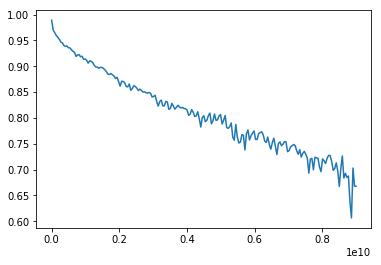

In [19]:
plt.plot(f, np.abs(s21))

In [2]:
import serial
ser = serial.Serial("COM6", 9600)
ser.write(b'C')

NameError: name 'ser' is not defined

# (Optional) List resources

In [31]:
# This is useful to check if GPIB or USB is valid.
import visa
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR',
 'ASRL4::INSTR',
 'ASRL10::INSTR',
 'ASRL18::INSTR',
 'GPIB0::1::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::15::INSTR',
 'GPIB0::16::INSTR')

# S21 vs Freq, 1D, single scan

In [7]:
#################################################################################
# set up parameters
startFreq, endFreq = 5.948e9, 5.960e9
power = -75
numPoints, IFbandwidth, avg = 401, 500, 1
volt = 0

sampleID = 'I5'
suffix = '060519NbAlOx'  # suffix to the file name
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\SFQFlipIV\MCMunknown'
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\07242019'
#save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\011918_W14_HF blow dry'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W16\testing'
#save_path = r'Z:\User\JJ\SFQ3\HYP1'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W19\B3\ADR1'
# save_path = r'Z:\User\Andrew\Fluxnoise_measurements\AB26_30_RRR\AB26'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

 #file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

# sim_glb.setVoltage(volt)
# sim_1.setVoltage(volt)
#sim_p.setVoltage(2)
# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

 # save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 


# # Post measurement    
# sim_glb.setVoltage(0)
pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


In [26]:
sim_glb.setVoltage(0)

# S21 vs Freq vs Power, 2D power scan

startPwr=-90 dBm, endPwr=-30 dBm, current power=-30 dBm
Measurement complete!!!
Wall time: 12.6 s


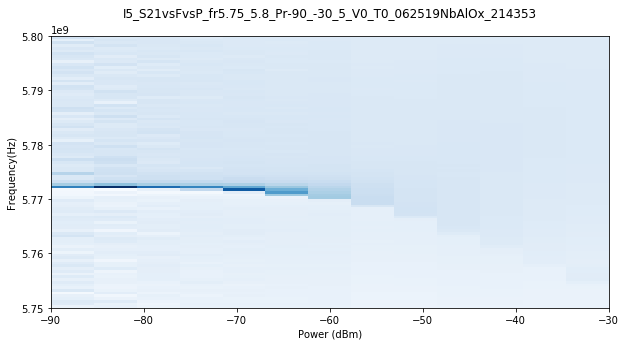

In [23]:
%%time
#########################################################################################
# set up parameters
# startFreq, endFreq =5.69537e9-100e3, 5.69537e9+100e3 

startFreq, endFreq = 5.75e9, 5.8e9
numPoints, avg =100, 5
IFStart, IFEnd = 500, 1000 # Hz
startPwr, endPwr, stepPwr = -90,-30, 5
Vglb_init = 0
Vchip_init = 0
V_init = 0

sampleID = 'I5'
suffix = '062519NbAlOx'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\postdescumRes'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\C6\DR1'
#save_path = r'Z:\User\JJ\SFQ2\070717C\ADR2\E3'
# save_path = r'Z:\PHY-PRL-Labshare\User\Andrew\Flip-Chip_measurements'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\SFQFlipIV\MCMunknown'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\Plaquette\RF_SQUID\0730'
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\07102019'
commentStr=''  # comment to be placed in the log file.
############################################################################################

# IFbandwidth scales up linearly as power increases.
IF_arr = np.linspace(IFStart, IFEnd, np.arange(startPwr, endPwr + stepPwr, stepPwr).size) 

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Power (dBm)', startPwr, endPwr, stepPwr
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('numPoints',numPoints), ('IFbandwidth start (Hz)', IF_arr[0]),('IFbandwidth end (Hz)', IF_arr[-1])
             , ('avg',avg), ('Vglb_init (V)',Vglb_init),('Vchip_init (V)',Vchip_init), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_'+'S21vsFvsP_fr{:.9g}_{:.9g}_Pr{:.4g}_{:.4g}_{:.4g}_V{:.3g}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, startPwr, endPwr, stepPwr, Vglb_init, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
print('filename={}'.format(os.path.join(save_path, baseFileName + '_mag.dat')))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency(Hz)', xlabel='Power (dBm)', title = baseFileName)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()
sim_1.setVoltage(V_init)
#sim_chip.setVoltage(Vchip_init)
#sim_1.setVoltage(V_init)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

i=0
# sweep start
for pwr in np.arange(startPwr, endPwr + stepPwr, stepPwr): # traverse in [pmin, pmax].
    
    clear_output()
    print('startPwr={:.3g} dBm, endPwr={:.3g} dBm, current power={:.3g} dBm'.format(startPwr, endPwr, pwr))
    
    # configure
    pna.setIF(IF_arr[i]) 
    pna.setPwr(pwr)
    pna.avgClear()
    i += 1
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
     
    # plot update
    extent = [startPwr, pwr, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
# Post measurement  
pna.setPwr(-70)
pna.pwrOff()
sim_1.setVoltage(0)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement complete!!!')


In [ ]:
%matplotlib
filename =r'Z:\User\Jaseung\projects\CSFQ\measurement\postdescumRes\Res1_S21vsFvsP_fr5.69532_5.69542_Pr-90_10_1_V0_T0.064__101617_mag.dat'
data = np.loadtxt(filename)
powerlist = np.arange(-90, 10,1)
# freq = 
for index, value in enumerate(powerlist):
    s21_mag = data[:,index]
    if index % 10 ==3:
        plt.plot(s21_mag )

# S21 vs Freq vs Flux, 2D flux scan

startV=-8 V, endV=8 V, current volt=8 V
Measurement done!!!
Wall time: 4min 1s


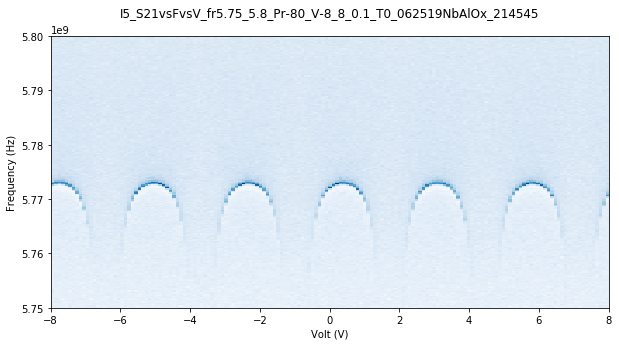

In [25]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 5.75e9, 5.8e9
power = -80
numPoints, IFbandwidth,avg = 200, 10000, 40
startVolt, endVolt, stepVolt = -8, 8, 0.1

sweepVoltSrc = 1 # 1: Vchip, 2: Vglb
Vglb_init = 0
Vglb_end = 0  
Vchip_init =0
Vchip_end = 0

sampleID = 'I5'
suffix = '062519NbAlOx'
#save_path = r'Z:\PHY-PRL-Labshare\Experiments\Dirty Aluminum\Super_Inductor\0322'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W19\A4\ADR2'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\Plaquette\RF_SQUID\0730'
#save_path = r'C:\Users\Lab User\Desktop\Crap, please organize\SFQFlipIV\MCMunknown'
#save_path = r'Z:\Experiments\Dirty Aluminum\Super_Inductor\0418'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W14\B8\ADR2'
#save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF'
#save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\BF'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\A8\ADR2'
# save_path = r'Z:\Experiments\Dirty Aluminum\RF_SQUID\0602\recool'
save_path = r'Z:\Experiments\Dirty Aluminum\Qubit\07102019'
commentStr =''
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = 0 #FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

# sim_.setVoltage(startVolt)
sim_1.setVoltage(Vchip_init)
sim_3.setVoltage(startVolt)
#sim_chip.setVoltage(startVolt)
#sim_p.setVoltage(startVolt)

time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    clear_output()
    print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

    # configure
    if sweepVoltSrc==1:
        sim_1.setVoltage(volt)
#         pass
    elif sweepVoltSrc==2:
        sim_2.setVoltage(volt)
        
    #time.sleep(0.5)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        #S21_mag_log_2D = S21_real
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        #S21_phase_2D = S21_imag
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
        #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
        #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))
    
    # plot update
    extent = [startVolt, volt, startFreq, endFreq]

        
    # save data in each iteration
#     f_mag = open(dataFileName_mag, 'w') 
#     f_phase = open(dataFileName_phase, 'w') 
#     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
#     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
#     f_mag.close()
#     f_phase.close()
    
############## sweep end #########################    
# save at the end
plotobj.update(S21_mag_log_2D, extent)
f_mag = open(dataFileName_mag, 'wb') 
f_phase = open(dataFileName_phase, 'wb') 
np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
f_mag.close()
f_phase.close()

 
# Post measurement   
plotobj.update(S21_mag_log_2D, extent)
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
sim_1.setVoltage(0)
sim_3.setVoltage(0)
#sim_chip.setVoltage(Vchip_end)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

In [ ]:
%%time
###########################################################################
# set up parameters
def starkvsflux( flux, freqstart, freqend):
    startFreq, endFreq = 5.17e9, 5.19e9
    power = -73
    numPoints, IFbandwidth, avg = 800, 500, 50
    startVolt, endVolt, stepVolt = -1.5, 1.5, 0.5

    sweepVoltSrc = 1 # 1: Vchip, 2: Vglb
    #Vglb_init = 0
    #Vglb_end = 0  
    #Vchip_init =0
    #Vchip_end = 0

    sampleID = 'Q1'
    suffix = ''
    
    save_path = r'Z:\PHY-PRL-Labshare\User\Andrew\Flip-Chip_measurements\JN90_MCM16'
    #save_path = r'Z:\User\Andrew\Flip-Chip_measurements\HYP2'
    #save_path = r'C:\Users\Lab User\Desktop\Plaquette\RF_SQUID\0602'
    #save_path = r'Z:\User\JJ\SFQ3\HYP1'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W14\B8\ADR2'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF'
    #save_path=r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\BF'
    #save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\A8\ADR2'
    #save_path = r'Z:\User\Caleb\ch061'
    #save_path = r'C:\Users\Lab User\Desktop\Flux'
    commentStr =''
    ############################################################################

    # dictionary for parameters to be saved in json file. Solely for log.
    xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
    yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
    para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
                 , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
                 , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
                 , ('avg',avg), ('comment', commentStr)])

    # file setup
    if fridgeType=='ADR2':
        
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0    
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + '_phase.dat'))
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot2D(ylabel = 'Frequency (Hz)', xlabel='Volt (V)', title = baseFileName)

    # preconfigure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    sim_glb.setVoltage(Vglb_init)
    #sim_chip.setVoltage(Vchip_init)
    sim_glb.setVoltage(startVolt)
    #sim_chip.setVoltage(startVolt)
    #sim_p.setVoltage(startVolt)

    time.sleep(2)

    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    ################ sweep start ################
    for volt in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt))

        # configure
        if sweepVoltSrc==1:
            sim_chip.setVoltage(volt)
    #         pass
        elif sweepVoltSrc==2:
            sim_p.setVoltage(volt)

        #time.sleep(0.5)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            #S21_mag_log_2D = S21_real
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            #S21_phase_2D = S21_imag
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
            #S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_real))
            #S21_phase_2D = np.column_stack((S21_phase_2D, S21_imag))

        # plot update
        extent = [startVolt, volt, startFreq, endFreq]
        #plotobj.update(S21_mag_log_2D, extent)

        # save data in each iteration
    #     f_mag = open(dataFileName_mag, 'w') 
    #     f_phase = open(dataFileName_phase, 'w') 
    #     np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    #     np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    #     f_mag.close()
    #     f_phase.close()

    ############## sweep end #########################    
    # save at the end
    f_mag = open(dataFileName_mag, 'wb') 
    f_phase = open(dataFileName_phase, 'wb') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()


    # Post measurement   
    del S21_mag_log_2D, S21_phase_2D
    pna.pwrOff()
    sim_p.setVoltage(Vglb_end)
    sim_chip.setVoltage(Vchip_end)
    plotobj.update(S21_mag_log_2D, extent)
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement done!!!')

# S21 vs Freq vs Flux, 3D flux scan

In [ ]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq = 6e9, 6.13e9 # 6.935e9, 6.9450e9 #6.7949e9 , 6.9676e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -68
numPoints, IFbandwidth, avg = 801, 200, 10
startVolt, endVolt, stepVolt = -1, 1, 0.1 #-5, 5, 0.05 #  #-15, 15, 0.4#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0  # end voltage for both global and onchip flux
#startVolt1, endVolt1, stepVolt1 =-5.3, 0.7, 0.05

#slop, Vglb_offset = -0.0659, -0.5  # Vglb = slope * Vchip + Vglb_offset. Vglb_offset is the y-intercept in Vchip(x-axxis) vs Vglb (y) axis.

#save_path = 'Z:\User\JJ\SFQ2\C6'
save_path = 'Z:\User\Jaseung\projects\CSFQ\measurement\W3\B7\BlueFors\Jan2017\S21vsFreqvsV\AlongNormVchipAxis'
suffix = 'Q1_VchipAxis'
commentStr= 'slope={:.3g}, Vglb_offset={:.3g}'.format(slope, Vglb_offset)
############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
zID, zStart, zEnd, zStep = 'Volt (V)', startVolt1, endVolt1, stepVolt1
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             ,('zID', zID), ('zStart', zStart), ('zEnd', zEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# log file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0
timeStr = time.strftime("%H%M%S")
baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix,timeStr)
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
#plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = 'S21 vs Freq vs Volt')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope * startVolt + Vglb_offset)
sim_chip.setVoltage(startVolt)

time.sleep(2)

################ sweep start ################
for Vglb_offset in np.arange(startVolt1, endVolt1+stepVolt1, stepVolt1):
    # data initialization
    S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

    #sim_glb.setVoltage(volt_outer)
    
    for volt_inner in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
        clear_output()
        print('Vglb_offset={:.3g}'.format(Vglb_offset))
        print('startV={:.3g} V, endV={:.3g} V, current volt={:.3g} V'.format(startVolt, endVolt, volt_inner))

        # configure
        sim_chip.setVoltage(volt_inner)
        sim_glb.setVoltage(slope * volt_inner + Vglb_offset)
        time.sleep(0.1)
        pna.avgClear()

        # fetch data from PNA
        freq, S21 = pna.getData(cplx=True) # S21 in linear scale

        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
            S21_mag_log_2D = S21_mag_log
            S21_mag_log_2D.shape = (S21_mag_log.size, 1)
            S21_phase_2D = S21_phase
            S21_phase_2D.shape = (S21_phase.size, 1)
        else:
            S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
            S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))

        # plot update
        #extent = [startVolt, volt, startFreq, endFreq]
        #plotobj.update(S21_mag_log_2D, extent)
     
    sim_chip.setVoltage(endV)
    time.sleep(3)
     
    # save at the end of inner loop
    fileIdStr = '_Vglb_offset={:.3g}'.format(Vglb_offset)
    dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + fileIdStr + '_mag.dat'), 
                                             os.path.join(save_path, baseFileName + fileIdStr + '_phase.dat'))
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
############## sweep end #########################    

# Post measurement   
del S21_mag_log_2D, S21_phase_2D
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
print('Measurement done!!!')

# S21 vs Flux1 vs Flux2, 2D flux scan

In [ ]:
%reset

In [ ]:
import sys
for i in dir():
    try:
        print (i, eval(i).nbytes )
    except:
        print (i, sys.getsizeof(eval(i)) )

In [ ]:
%%time
##############################################################################
# set up parameters
readoutPwr = -75
readoutFreq = 7.14567e9 #6.7917e9 #6.792e9 #6.82e9 
numPoints, IFbandwidth, avg = 30, 500, 1
startVolt1, endVolt1, stepVolt1 =-3, 3, 0.02#-10, 10, 0.2 #-10, 10, 0.05 #-1.2, 1, 0.025 # outer for-loop
startVolt2, endVolt2, stepVolt2 =-20,20, 0.25 #-20, 20, 0.5 #-20, 20, 0.5 # y axis. Inner for-loop.
endVolt = 0

suffix = 'Q6_V2=onchip'
save_path =  r'Z:\User\Jaseung\projects\CSFQ\measurement\W10\B2\ADR2'
commentStr='with spec setup'
##############################################################################

xID, xStart, xEnd, xStep = 'Volt1 (V)', startVolt1, endVolt1, stepVolt1
yID, yStart, yEnd, yStep = 'Volt2 (V)', startVolt2, endVolt2, stepVolt2
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd)
             , ('readoutFreq (Hz)',readoutFreq),('power (dBm)',readoutPwr)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', commentStr)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else:
    FAA = 0

baseStr = 'S21vsV1vsV2_fr{:.9g}_Pr{:.4g}_V1_{}_{}_{}_V2_{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt1, endVolt1, stepVolt1, startVolt2, endVolt2, stepVolt2, FAA, suffix)
dataFileName1  = os.path.join(save_path, baseFileName + '_mag.dat')
dataFileName2  = os.path.join(save_path, baseFileName + '_phase.dat')
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f_log:
    json.dump(para, f_log, indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot2D_4sub(xlabel1 = 'Voltage2 (V)', ylabel1='S21 (dB)', 
                             xlabel2 = 'Voltage2 (V)', ylabel2='Phase(degree)',
                             xlabel3 = 'Voltage, Vglb (V)', ylabel3='Voltage, Vchip (V)',
                             xlabel4 = 'Voltage, Vglb (V)', ylabel4='Voltage, Vchip (V)',
                             title = 'S21 vs Global Flux vs Gradiometric Flux', figsize=(12,8))

# preconfigure instrument
pna.setupMeas()
pna.setSweepType(mode='CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(startVolt1)
time.sleep(2)
sim_chip.setVoltage(startVolt2)
time.sleep(2)

# data initialization
data1_2D, data2_2D = np.array([]), np.array([])

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
for volt1 in np.arange(startVolt1, endVolt1 + stepVolt1, stepVolt1):
    #configure para
    sim_glb.setVoltage(volt1)
    
    # data initialization
    xdata1, ydata1, ydata2 = np.array([]), np.array([]), np.array([])
    
    for volt2 in np.arange(startVolt2, endVolt2 + stepVolt2, stepVolt2):
        clear_output()
        print('startVolt1={:.3g}, endtvolt1={:.3g}'.format(startVolt1, endVolt1))
        print('startVolt2={:.3g}, endtvolt2={:.3g}'.format(startVolt2, endVolt2))
        print('volt1={:.3g}, volt2={:.3g}'.format(volt1, volt2)) 
        
        # configure
        pna.avgClear()
        sim_chip.setVoltage(volt2)
    
        # fetch data from PNA
        freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
        # S21 conversion
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

        S21_mag_log_avg = np.average(S21_mag_log) 
        S21_phase_avg = np.average(S21_phase)

        xdata1 = np.append(xdata1, volt2)
        ydata1 = np.append(ydata1, S21_mag_log_avg)
        ydata2 = np.append(ydata2, S21_phase_avg)

        # plot and update
        plotobj.update1D(xdata1, ydata1, xdata1, ydata2)

    
    if data1_2D.size == 0: # when S21_mag_2D is empty
        data1_2D = ydata1 # make 2D array
        data1_2D.shape = (data1_2D.size, 1)
        data2_2D = ydata2
        data2_2D.shape = (data2_2D.size, 1)
        
    else:
        data1_2D = np.column_stack((data1_2D, ydata1))
        data2_2D = np.column_stack((data2_2D, ydata2))
             
    # plot and update
    extent = [startVolt1, volt1, startVolt2, endVolt2]
    plotobj.update2D(data1_2D, data2_2D, extent, cmap='Blues_r')
    
    # save data in each iteration
    f_mag = open(dataFileName1, 'wb') 
    f_phase = open(dataFileName2, 'wb') 
    np.savetxt(f_mag, data1_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, data2_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
     
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endVolt)
sim_chip.setVoltage(endVolt)
f_log.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq vs Flux (linear comb. of flux1 and flux2), 2D

In [ ]:
reload(myplots)

In [ ]:
%%time
###########################################################################
# set up parameters
startFreq, endFreq =  6.77e9, 6.81e9 #6.83e9, 6.894e9#6.856e9, 7.015e9 #6.85e9, 7.05e9
power = -60
numPoints, IFbandwidth, avg = 801, 1000, 1
startVolt, endVolt, stepVolt =-20, 20, 0.2#-20, 20, 0.5 #-1, 1.5, 0.04
endV = 0

slope, Vglb_offset =-0.3378,2.4 # 0.2107, 0# 2.484#-0.3378, -0.9641# -0.0659, 0.7   # offset means Vglb when Vchip=0

#save_path = 'Z:\User\JJ\sput\M5_1_spec'
save_path = 'Z:\User\Jaseung\projects\CSFQ\measurement\W3\B7\BlueFors\Jan2017\S21vsFreqvsV'
suffix = 'Q1_xID=Vchip_slope{}_Vglb_offset{}'.format(slope, Vglb_offset)
comment= 'slope={:.3g}, Vglb_offset={:.3g}'.format(slope, Vglb_offset)

plottitle = 'S21 vs Freq vs Vchip, Vglb_offset={:.3g}'.format(Vglb_offset)

############################################################################

# dictionary for parameters to be saved in json file. Solely for log.
xID, xStart, xEnd, xStep = 'Volt (V)', startVolt, endVolt, stepVolt
yID, yStart, yEnd, yStep = 'Frequency (Hz)',startFreq, endFreq, (endFreq-startFreq)/(numPoints-1)
para = dict([('xID', xID), ('xStart', xStart), ('xEnd', xEnd)
             , ('yID', yID), ('yStart', yStart), ('yEnd', yEnd), ('Power (dBm)', power)
             , ('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth) 
             , ('avg',avg), ('comment', comment)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else FAA = 0

baseStr = 'S21vsFvsV_fr{:.9g}_{:.9g}_Pr{:.4g}_V{}_{}_{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, startVolt, endVolt, stepVolt, FAA, suffix)
dataFileName_mag, dataFileName_phase  = (os.path.join(save_path, baseFileName + '_mag.dat'), 
                                         os.path.join(save_path, baseFileName + '_phase.dat'))
logFileName =  os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots.plot2D(ylabel = 'Frequency(Hz)', xlabel='Volt (V)', title = plottitle)

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(slope*startVolt+Vglb_offset)
sim_chip.setVoltage(startVolt)
time.sleep(2)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for volt_chip in np.arange(startVolt, endVolt + stepVolt, stepVolt): # traverse in [pmin, pmax].
    # configure
    volt_glb =  slope * volt_chip + Vglb_offset
    #volt_glb = -1/slope* (volt_chip-20) - 0.55
    clear_output()
    print('volt_glb={:.3g}, volt_chip={:.3g}'.format(volt_glb, volt_chip))
    sim_chip.setVoltage(volt_chip)
    sim_glb.setVoltage(volt_glb)
    
    time.sleep(0.1)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    if S21_mag_log_2D.size == 0: # when S21_mag_2D is empty
        S21_mag_log_2D = S21_mag_log
        S21_mag_log_2D.shape = (S21_mag_log.size, 1)
        S21_phase_2D = S21_phase
        S21_phase_2D.shape = (S21_phase.size, 1)
    else:
        S21_mag_log_2D = np.column_stack((S21_mag_log_2D, S21_mag_log))
        S21_phase_2D = np.column_stack((S21_phase_2D, S21_phase))
     
    # plot update
    extent = [startVolt, volt_chip, startFreq, endFreq]
    plotobj.update(S21_mag_log_2D, extent)
        
    # save data in each iteration
    f_mag = open(dataFileName_mag, 'w') 
    f_phase = open(dataFileName_phase, 'w') 
    np.savetxt(f_mag, S21_mag_log_2D, fmt='%.9g', delimiter='\t') 
    np.savetxt(f_phase, S21_phase_2D, fmt='%.9g', delimiter='\t')
    f_mag.close()
    f_phase.close()
    
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
sim_glb.setVoltage(endV)
sim_chip.setVoltage(endV)
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!!')

# S21 vs Freq, 1D continuous sweep, no save

In [ ]:
# set up parameters
startFreq, endFreq = 6e9, 6.867e9
power = -60
numPoints, IFbandwidth, avg = 401, 500, 1
#volt = 0.0 # -0.65 # -2.05  #2.4

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = 'S21 vs Freq'
                        , plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
#sim_glb.setVoltage(volt)

# data initialization
S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])

################ sweep start ################
for i in range(400):
    # configure
    pna.avgClear()
        
    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    
    # plot update
    plotobj.update(freq/1e9, S21_mag_log)
       
############## sweep end #########################    

# Post measurement    
pna.pwrOff()


# S21 vs Flux, 1D, CW mode

In [ ]:
####################################################################################################
# set up parameters
readoutFreq = 6.9078e9 #6.9180e9 #6.873328e9
readoutPwr = -70
numPoints, IFbandwidth, avg = 50, 100, 1
startVolt, endVolt, stepVolt =0.2, 0.5, 0.003
endV = 0
sweepNumber = 1
timesleep = 0.1 # sec

sampleID = 'IBM384QB56'
suffix = 'Q2CSFQ'
# save_path = 'C:\Users\Lab User\Desktop\W4'
#save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\W11\DD5\ADR2'
save_path = r'Z:\User\Jaseung\projects\CSFQ\measurement\IBM\384QB56\BF\With_circulators'
#save_path = r'Y:\User\Caleb'
######################################################################################################

# dictionary for parameters to be saved in json file. Solely for log.
header = '{:s} {:s} {:s}'.format('Frequency(Hz)', 'mag(dB)', 'phase(degree)')
para = dict([('readout Freq (Hz)',readoutFreq),('readout Power (dBm)', readoutPwr),('numPoints',numPoints),
             ('IFbandwidth (Hz)', IFbandwidth),('avg',avg),('start volt (V)',startVolt),('end volt (V)', endVolt),
             ('step volt (V)',stepVolt), ('header', header)])


# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0    
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsV_fr{:.9g}_Pr{:.9g}_V{:.9g}_{:.9g}_{:.9g}_T{:.3g}_{}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, readoutPwr, startVolt, endVolt, stepVolt, FAA, suffix, timeStr)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

f_data = open(dataFileName, 'a')
   
# plot setup
plotobj= myplots_py3.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = baseFileName, plotStyle='b-')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.setPwr(readoutPwr)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#spec.pwrOff()
sim_glb.setVoltage(startVolt)
#sim_chip.setVoltage(0)

#sim_glb.setVoltage(0.148)
#sim_chip.setVoltage(startVolt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startVolt, end=endVolt, 
                            step=stepVolt, sweepNum=sweepNumber)

################ sweep start ################
#for specFreq in arange(startFreq, endFreq + stepFreq, stepFreq): # traverse in [pmin, pmax].
print(sweeper.stop())

while not sweeper.stop(): 
    # configure
    sim_glb.setVoltage(sweeper.curr_val)
    #sim_chip.setVoltage(sweeper.curr_val)
    
    time.sleep(timesleep) # sec
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
sim_glb.setVoltage(endV)
#sim_chip.setVoltage(endV)
f_data.close()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement done!!')


# S21 vs P, 1D, CW mode

In [ ]:
##################################################################
# set up parameters
readoutFreq = 6.103142e9 #6.873328e9
numPoints, IFbandwidth, avg = 50, 200, 1
startPwr, endPwr, stepPwr = -70, -40, 0.5
volt = 0
sweepNumber = 1

sampleID = ''
suffix = ''  # suffix to the file name
save_path = 'C:\Users\Lab User\Desktop\JJ\A4'
#save_path = 'Z:\User\Jaseung\projects\CSFQ\W1\C5\S21vsFreq'
##################################################################

# dictionary for parameters to be saved in json file. Solely for log.
para = dict([('readout Freq (Hz)',readoutFreq),('numPoints',numPoints)
             ,('IFbandwidth', IFbandwidth),('avg',avg)
             ,('Power start (dBm)',startPwr),('Power end (dBm)',endPwr), ('Power step (dBm)',stepPwr)
             ,('voltage (V)',volt)])

# file setup
FAA = float(lsci.tempGet('B')) # unicode to num    
baseStr = sampleID + '_S21vsP_fr{:.9g}_Pr{:.9g}_{:.9g}_{:.9g}_V{:.3g}_T{:.4g}_{}'
baseFileName = baseStr.format(readoutFreq/1e9, startPwr, endPwr, stepPwr, volt, FAA, suffix)
dataFileName  = os.path.join(save_path, baseFileName + '.dat')
logFileName = os.path.join(save_path, baseFileName + '.json')
with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)
f_data = open(dataFileName, 'a')
    
# plot setup
plotobj= myplots.plot1D_2sub(xlabel1 = '', ylabel1='S21 (dB)', 
                             xlabel2 = 'Volt (V)', ylabel2='Phase(degree)',
                             title = 'S21 vs Volt', plotStyle='b-o')

# preconfigure instrument
pna.setupMeas()
pna.setSweepType('CW')
pna.setCWFreq(readoutFreq)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()
#spec.pwrOff()
sim_glb.setVoltage(volt)

# data initialization
xdata, ydata1, ydata2 = np.array([]), np.array([]),np.array([])

# sweeper obj
sweeper = myutils.Sweeper1D(start=startPwr, end=endPwr, step=stepPwr, sweepNum=sweepNumber)

################ sweep start ################
while not sweeper.stop(): 
    # configure
    pna.setPwr(sweeper.curr_val)
    pna.avgClear()
    
    # fetch data from PNA
    freq, S21= pna.getData(cplx=True) # S21 in linear scale
    
    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB
    S21_mag_log_avg = np.average(S21_mag_log) 
    S21_phase_avg = np.average(S21_phase)
    
    # create spec freq, S21 1D array
    xdata = np.append(xdata, sweeper.curr_val)
    ydata1 = np.append(ydata1, S21_mag_log_avg)
    ydata2 = np.append(ydata2, S21_phase_avg)
    
    # plot and update
    plotobj.update(xdata, ydata1, xdata, ydata2)
    
    # save data in each iteration
    string = '{:.9g}\t{:.3g}\t{:.3g} \n'.format(sweeper.curr_val, S21_mag_log_avg,S21_phase_avg)
    f_data.write(string)
    
    # update sweep
    sweeper.update()
############## sweep end #########################    

# Post measurement    
pna.pwrOff()
pna.setSweepType(mode='linear')
#sim_glb.setVoltage(endV)
f_data.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

# Resonator Power scan

In [4]:
#################################################################################
# set up parameters
startFreq, endFreq =6.407e9, 6.408e9
power = -20
numPoints, IFbandwidth, avg = 1001, 1000, 3
volt = 0 # -0.65 # -2.05  #2.4

sampleID = 'W19B4'
suffix = 'R4'  # suffix to the file name
#save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\12062017_W10'
save_path = r'Z:\User\Yebin\Project\Resonator Qi test\Samples\07022018-W19-HF after photolithography_ADR2'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

# file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

#sim_glb.setVoltage(volt)

# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

# Post measurement   

pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


In [5]:
def cav1d(startFreq, endFreq,power,numPoints, IFbandwidth, avg,width,suffix = 'R5',sampleID ='W5', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples\02192018_W5Res_HFinCNF_Post descum\data\R5'):
    #################################################################################
    # set up parameters   
    volt = 0 # -0.65 # -2.05  #2.4
    #suffix = 'Q4'  # suffix to the file name
    #################################################################################

    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])

    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0.0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,width,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')

    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)

    # plot setup
    plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

    # configure instrument
    pna.setupMeas()
    pna.setSweepType('linear')
    pna.setFreqStartEnd(startFreq, endFreq)
    pna.setPwr(power)
    pna.avgCount(avg)
    pna.numPoints(numPoints)
    pna.setIF(IFbandwidth)
    pna.pwrOn()

    #sim_glb.setVoltage(volt)

    # data initialization
    #S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
    data = np.array([])

    # configure
    pna.avgClear()

    # fetch data from PNA
    freq, S21 = pna.getData(cplx=True) # S21 in linear scale

    # S21 conversion
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

    # make 2D array with freq, dB, phase
    data = freq
    data.shape = (freq.size, 1)
    data = np.column_stack((data, S21_mag_log))
    data = np.column_stack((data, S21_phase))
    data = np.column_stack((data, S21_real))
    data = np.column_stack((data, S21_imag))

    # plot update
    plotobj.update(freq/1e9, S21_mag_log)

    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 

    # Post measurement    
    pna.pwrOff()
    f.close()
    plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
    print('Measurement finished!!!')
    return data

In [6]:
def Get_S21(freqStart, freqEnd,power,numPoints, IFbandwidth, avg,wideSpan,suffix = 'Q4',sampleID ='W14', \
          save_path=r'Z:\User\Yebin\Project\Resonator Qi test\Samples'):
    #get data 1 WS scan
    freqCenter = (freqStart + freqEnd)/2
    freqStartW = freqCenter - wideSpan/2
    freqEndW = freqCenter + wideSpan/2 
    dataS = cav1d(freqStart, freqEnd,power,numPoints,IFbandwidth, avg,'SS',suffix,sampleID,save_path) 
    dataW = cav1d(freqStartW, freqEndW,power,numPoints,IFbandwidth, avg,'WS',suffix,sampleID,save_path) 
    
    volt = 0
    
    # fit baseline
    p = len(dataW[:,0])
    w = int(p/5)
    freqW,freqW1,freqW2 = [],dataW[0:w,0] , dataW[(p-w):p,0]
    freqW.extend(freqW1)
    freqW.extend(freqW2)
    magdataW,magdataW1,magdataW2 =  [],dataW[0:w,1], dataW[(p-w):p,1]
    magdataW.extend(magdataW1)
    magdataW.extend(magdataW2)
    phasedataW,phasedataW1,phasedataW2 =  [],dataW[0:w,2] , dataW[(p-w):p,2]
    phasedataW.extend(phasedataW1)
    phasedataW.extend(phasedataW2)
    magBasePara = np.polyfit(freqW,magdataW,2)
    phaseBasePara = np.polyfit(freqW,phasedataW,1)
    magBaseFit = np.polyval(magBasePara,dataS[:,0])
    phaseBaseFit = np.polyval(phaseBasePara,dataS[:,0])
    # base line subtraction
    magSub = dataS[:,1] - magBaseFit
    phaseSub = dataS[:,2] - phaseBaseFit
    dataS[:,1] = magSub
    dataS[:,2] = phaseSub
    # dictionary for parameters to be saved in log file.
    header = 'freq (Hz) mag(dB) phase(degree) real imag'
    para = dict([('power (dBm)',power),('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq)
                 ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
                 ,('volt',volt), ('header', header)])
    # file setup
    if fridgeType=='ADR2':
        FAA = float(lsci.tempGet('B')) # get temperature
    else :
        FAA = 0 
    timeStr = time.strftime("%H%M%S")
    baseStr = sampleID + '_S21vsF_Sub_Pr{}_fr{:.9g}_{:.9g}_V{}_T{:.4g}_{}_{}'
    baseFileName = baseStr.format(power,startFreq/1e9, endFreq/1e9, volt, FAA,suffix, timeStr)
    dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
    logFileName =  os.path.join(save_path, baseFileName + '.json')
    with open(logFileName, 'w') as f:
        json.dump(para,f,indent=4, sort_keys=True)
    # save files
    f = open(dataFileName, 'wb') 
    np.savetxt(f, data, fmt='%.9g', delimiter='\t') 
    f.close()

In [7]:
startFreq, endFreq =6.4074e9, 6.4077e9
wideSpan = 10e6
suffix = 'R5_RTAtt10'
sampleID = 'W19B4'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\07022018-W19-HF after photolithography_ADR2\R5_Only resonator side is closed'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [1000,
               1000,1000,1000,1000,1000,1000,1000,1000,1000,
               100,100,10,10,10,10,10,10,10,10,10]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,20,50,60,80,100,100,200,200]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,201,
            201,201,201,201,201,201,201,201,201,201]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initiali

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'


KeyboardInterrupt: 

In [45]:
startFreq =6.21875e9
endFreq= 6.21905e9
wideSpan = 10e6
suffix = 'R4_RTAtt30'
sampleID = 'W17B5'
save_path =  r'Z:\User\Yebin\Project\Resonator Qi test\Samples\05142018-W17B5_Furnace_post descum\R4'
'''
power = [10,
         5,0,-5,-10,-15,-20,-25,-30,-35,
         -40,-45,-50,-55,-60,-65,-70,-75,-80,-85,-90]
IFbandwidth = [10,
               10,10,10,10,10,10,10,10,10,
               1,1,1,1,1,1,1,1,1,1,1]
avg = [4,
       4,4,4,8,8,8,10,10,10,
       10,15,20,30,40,80,80,160,160,250,320]
numPoints = [501,
             501,501,501,301,301,301,201,201,201,101,
            101,101,101,101,101,101,101,101,101,101]
'''
#####
power = [-85,-90]
IFbandwidth = [1,1]
avg = [40,40]
numPoints = [51,51]
##########################
# power = [0,-2,-4,-6,-8,-10,-12,-14,-16,-18]
# IFbandwidth = [5000,5000,5000,5000,5000,5000,5000,5000,5000,5000]
# avg = [20,20,20,20,20,20,20,20,20,20]
# numPoints = [201,201,201,201,201,201,201,201,201,201]
for i in range(len(power)):
    #Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)
    Get_S21(startFreq, endFreq,power[i],numPoints[i], IFbandwidth[i], avg[i],wideSpan,suffix ,sampleID, save_path)

Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!
Initialized S21 Measurement 'S21Meas'
Measurement finished!!!


# Playground. Try things out below.

In [5]:
startIP, endIP, RP = -0.03e-3, 0.03e-3,2e3
startIS, endIS, RS = -6e-3, 6e-3,2e3
N = 200
startVP = startIP*RP
endVP = endIP*RP
startVS = startIS*RS
endVS = endIS*RS
plaqStep = 0.1/8
sqdStep = plaqStep*6.05144
i=33
j=73


VPlist = np.linspace(startVP+plaqStep*j,endVP+plaqStep*(j),N)
VSlist = np.linspace(startVS+sqdStep*j,endVS+sqdStep*j,N)

print(np.interp(i,np.linspace(1,N,N),VPlist/RP))
print(np.interp(i,np.linspace(1,N,N),VSlist/RS))

0.00043589824120603013
-0.001309382258793969


In [ ]:
#################################################################################
# set up parameters
startFreq, endFreq =6.0382e9, 6.039e9
power = -40 
numPoints, IFbandwidth, avg = 501, 1000, 10
volt = 0 # -0.65 # -2.05  #2.4

sampleID = 'FlipchipAB14'
suffix = 'cav2'  # suffix to the file name
savepath = r'Z:\User\Andrew\Flip-Chip_measurements\AB14\cavity_fit_Qc'
#################################################################################

# dictionary for parameters to be saved in log file.
header = 'freq (Hz) mag(dB) phase(degree) real imag'
para = dict([('startFreq (Hz)',startFreq),('endFreq (Hz)', endFreq),('power (dBm)',power)
             ,('numPoints',numPoints), ('IFbandwidth (Hz)', IFbandwidth),('avg',avg)
             ,('volt',volt), ('header', header)])

 #file setup
if fridgeType=='ADR2':
    FAA = float(lsci.tempGet('B')) # get temperature
else :
    FAA = 0 
timeStr = time.strftime("%H%M%S")
baseStr = sampleID + '_S21vsF_fr{:.9g}_{:.9g}_Pr{}_V{}_T{:.4g}_{}'
baseFileName = baseStr.format(startFreq/1e9, endFreq/1e9, power, volt, FAA, timeStr)
dataFileName = os.path.join(save_path, baseFileName + '.dat')                                 
logFileName =  os.path.join(save_path, baseFileName + '.json')

with open(logFileName, 'w') as f:
    json.dump(para,f,indent=4, sort_keys=True)

# plot setup
plotobj= myplots_py3.plot1D(ylabel = 'S21 (dB)', xlabel='Frequency (Hz)', title = baseFileName, plotStyle='b-')

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.setIF(IFbandwidth)
pna.pwrOn()

sim_glb.setVoltage(volt)

# data initialization
#S21_mag_log_2D, S21_phase_2D = np.array([]), np.array([])
data = np.array([])

# configure
pna.avgClear()
        
# fetch data from PNA
freq, S21 = pna.getData(cplx=True) # S21 in linear scale
 
# S21 conversion
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)    # dB

# make 2D array with freq, dB, phase
data = freq
data.shape = (freq.size, 1)
data = np.column_stack((data, S21_mag_log))
data = np.column_stack((data, S21_phase))
data = np.column_stack((data, S21_real))
data = np.column_stack((data, S21_imag))
     
# plot update
plotobj.update(freq/1e9, S21_mag_log)

# save files
f = open(dataFileName, 'wb') 
#np.savetxt(f, data, fmt='%.9g', delimiter='\t') 
np.savetxt(savepath+'Induc_cav_300um'+'.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter = '\t',newline = '\r\n',fmt='%.10e')

# Post measurement    
pna.pwrOff()
f.close()
plotobj.fig.savefig(os.path.join(save_path, baseFileName + '.png'))
print('Measurement finished!!!')




In [17]:
pna.setupMeas()
freq, S21 = pna.getData(cplx=True)
S21_real, S21_imag = np.real(S21), np.imag(S21)
S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
S21_mag_log = 20.0 * np.log10(S21_mag)
np.savetxt(r'C:\Users\Lab User\Desktop\Crap, please organize\Plaquette\RF_SQUID\0730\Res712P30NL.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')

Initialized S21 Measurement 'S21Meas'


In [4]:
startFreq, endFreq = 9.445e9, 9.459e9
numPoints, avg = 1601, 20
power = -40
startVoltP, endVoltP, stepVoltP = -10, 10, .2
startVoltS, endVoltS, stepVoltS = 0, .2, .002

savepath = 'Z:\\Experiments\\Dirty Aluminum\\RF_SQUID\\0602\\scan28\\'

# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02D = np.array([])
S2D = np.array([])

plotobj= myplots_py3.plot2D(xlabel = 'Bobbin Current (mA)', ylabel='Plaquette Current (mA)')

for vp in np.linspace(startVoltP,endVoltP,(endVoltP-startVoltP)/stepVoltP+1):
    f01D = np.array([])
    S1D = np.array([])
    sim_p.setVoltage(vp)
    
    for vs in np.linspace(startVoltS,endVoltS,(endVoltS-startVoltS)/stepVoltS+1):
        sim_s.setVoltage(vs)
        time.sleep(0.2)
        pna.avgClear()
        
        freq, S21 = pna.getData(cplx=True)
        S21_real, S21_imag = np.real(S21), np.imag(S21)
        S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
        S21_mag_log = 20.0 * np.log10(S21_mag)
        np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
        f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
        Smin = min(S21_mag_log)
        if min(S21_mag_log) > -4:
            f0 = 9.11
        #f01D.append(f0)
        f01D = np.append(f01D,f0)
        S1D = np.append(S1D,Smin)
    
    if f02D.size == 0: # when S21_mag_2D is empty
        f02D = f01D
        f02D.shape = (f02D.size, 1)
        S2D = S1D
        S2D.shape = (S2D.size, 1)
    else:
        f02D = np.column_stack((f02D, f01D))
        S2D = np.column_stack((S2D, S1D))
    extent = [startVoltP/1000, vp/1000, startVoltS/2, endVoltS/2]
    plotobj.update(f02D, extent)
pna.pwrOff()
sim_p.setVoltage(0)
sim_s.setVoltage(0)

np.savetxt(savepath + 'Res91Pn8p8Sn5p5.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')

np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')


Initialized S21 Measurement 'S21Meas'


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.01, right=-0.01
  'left=%s, right=%s') % (left, right))


KeyboardInterrupt: 

In [114]:
sim_p.setVoltage(0)
sim_s.setVoltage(0)

In [131]:
(0.6e-6-7.5e-6)/2

-3.45e-06

In [133]:
startFreq, endFreq = 9.114e9, 9.118e9   #9.112e9, 9.121e9
numPoints, avg = 1600, 50
power = -60
startIP, endIP, RP = -7.5e-6, -3e-6,1e6
startIS, endIS, RS = 6e-3, 0,2e3
N = 200

savepath = 'Z:\\Experiments\\Dirty Aluminum\\RF_SQUID\\scan26\\'

startVP = startIP*RP
endVP = endIP*RP
startVS = startIS*RS
endVS = endIS*RS

VPlist = list(np.linspace(startVP,endVP,N))
VSlist = list(np.linspace(startVS,endVS,N))


# configure instrument
pna.setupMeas()
pna.setSweepType('linear')
pna.setFreqStartEnd(startFreq, endFreq)
pna.setPwr(power)
pna.avgCount(avg)
pna.numPoints(numPoints)
pna.pwrOn()

f02D = np.array([])
f01D = np.array([])
#S1D = np.array([])


plotobj= myplots_py3.plot2D(xlabel = 'Index', ylabel='Frequency (GHz)')
i=1
for (vp,vs) in zip(VPlist,VSlist):
    sim_p.setVoltage(vp)
    sim_s.setVoltage(vs)
    time.sleep(0.2)
    pna.avgClear()
        
    freq, S21 = pna.getData(cplx=True)
    S21_real, S21_imag = np.real(S21), np.imag(S21)
    S21_mag, S21_phase = np.sqrt(S21_real**2 + S21_imag**2), np.angle(S21, deg=True) # phase in degree
    S21_mag_log = 20.0 * np.log10(S21_mag)
    np.savetxt(savepath+'P'+str(vp)+'VS'+str(vs)+'V.txt',list(zip(freq,S21_mag_log,S21_phase)),delimiter='\t',newline='\r\n',fmt='%.10e')
    f0 = freq[list(S21_mag_log).index(min(S21_mag_log))]/1e9
    Smin = min(S21_mag_log)
    if min(S21_mag_log) > -4:
        f0 = 9.11
    f01D = np.append(f01D,f0)
    #S1D = np.append(S1D,Smin)
    
    if f02D.size == 0: # when S21_mag_2D is empty
        f02D = S21_mag_log
        f02D.shape = (f02D.size, 1)
    else:
        f02D = np.column_stack((f02D, S21_mag_log))
    extent = [1, i, startFreq, endFreq]
    i=i+1
    plotobj.update(f02D, extent)
pna.pwrOff()
sim_p.setVoltage(0)
sim_s.setVoltage(0)

#np.savetxt(savepath + 'Res91Pn8p8Sn5p5.csv',list(f02D),delimiter=',',newline='\r\n',fmt='%.10e')

#np.savetxt(savepath + 'Res91S21Pn8p8Sn5p5.csv',list(S2D),delimiter=',',newline='\r\n',fmt='%.10e')

plotobj2= myplots_py3.plot1D(ylabel = 'f0 (GHz)', xlabel='Index', title = baseFileName, plotStyle='b-')
plotobj2.update(list(np.linspace(1,N,N)), f01D)


Initialized S21 Measurement 'S21Meas'


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))


In [58]:
fileID = open('C:\\Users\\Lab User\\Desktop\\Plaquette\\RF_SQUID\\0602\\scan3\\Res91Pn10p10Sn8p8.csv','w')

In [126]:
len(f01D)

400

In [87]:
if 1 == 1:
    a=2

In [94]:
pna.pwrOff()
sim_p.setVoltage(0)
sim_s.setVoltage(0)

In [127]:
np.savetxt('Z:\\Presentations\\Skypes with Madison\\Res91f0s.csv',list(f01D),delimiter=',',newline='\r\n',fmt='%.10e')

In [60]:
list(f02D)

[array([ 9.11619238,  9.11604199,  9.11614225,  9.11616105,  9.11601066,
         9.1157788 ,  9.11581013,  9.11602319,  9.11621118,  9.11624251,
         9.11616105,  9.11617985,  9.11624251,  9.11631144,  9.11633651,
         9.11637411,  9.11633651,  9.11624878,  9.11628638,  9.11632398,
         9.11626131,  9.11620492,  9.1149203 ,  9.11856109,  9.11627385,
         9.11628638,  9.11634904,  9.11637411,  9.11635531,  9.11626131,
         9.11626131,  9.11634278,  9.11626131,  9.11688169,  9.11621745,
         9.11624251,  9.11630518,  9.11634904,  9.11635531,  9.11638038,
         9.11631144]),
 array([ 9.11604826,  9.11608585,  9.11604199,  9.11588533,  9.11577253,
         9.11602946,  9.11619238,  9.11621118,  9.11626131,  9.11619865,
         9.11616105,  9.11622998,  9.11634904,  9.11636158,  9.11633651,
         9.11633024,  9.11633024,  9.11628011,  9.11628011,  9.11624878,
         9.11611719,  9.11459445,  9.11026435,  9.11624251,  9.11635531,
         9.11633651,  9.1164

In [22]:
GPIB_ADDR = 18
measurements = []
rm = visa.ResourceManager()
instr = rm.get_instrument('GPIB0::' + str(GPIB_ADDR) + '::INSTR')
instr.ask('KRDG? 1')

'+'